# Análisis Geoespacial de Hurtos a Persona en Medellín - 2018
Este notebook presenta un análisis descriptivo y geoespacial de los delitos de hurto a persona en Medellín durante el año 2018, utilizando datos abiertos. El objetivo es explorar patrones espaciales mediante visualización con coordenadas geográficas.

In [17]:
%pip install matplotlib
%pip install geopandas
%pip install shapely
%pip install osmnx

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: matplotlib in c:\users\johanmum\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (3.7.3)




[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\johanmum\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\johanmum\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\johanmum\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\johanmum\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx as ox
import seaborn as sns
plt.style.use('seaborn-v0_8')

## Carga y visualización inicial de los datos

In [19]:
pd.set_option('display.max_columns', None)

In [25]:
df = pd.read_parquet('.\data\hurto_a_persona.parquet.gzip')
df.head(3)

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,ocupacion,discapacidad,grupo_especial,medio_transporte,nivel_academico,testigo,conducta,modalidad,caracterizacion,conducta_especial,arma_medio,articulo_penal,categoria_penal,nombre_barrio,codigo_barrio,codigo_comuna,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion
0,2018-01-01T20:30:00.000-05:00,1.0,6.278325,-75.601265,Mujer,65,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Taxi,Sin dato,Sin dato,Hurto a persona,Atraco,Sin dato,Sin dato,Arma de fuego,Sin dato,Sin dato,Cucaracho,#0718,7,Vía pública,Castilla,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00
1,2018-01-02T18:30:00.000-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Visa,Documentos,Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00
2,2018-01-02T18:30:00.000-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00


## Conversión de tipos de datos y limpieza

In [21]:
df['fecha_hecho'] = pd.to_datetime(df['fecha_hecho'], errors='coerce')
df['latitud'] = pd.to_numeric(df['latitud'], errors='coerce')
df['longitud'] = pd.to_numeric(df['longitud'], errors='coerce')
df = df.dropna(subset=['latitud', 'longitud'])
df.shape

(257026, 36)

In [37]:
# Filtro geográfico por límites conocidos de Medellín
df_clean = df[
    (df['latitud'] >= 6.15) & (df['latitud'] <= 6.40) &
    (df['longitud'] >= -75.70) & (df['longitud'] <= -75.45)
].copy()



## Creación de geometría tipo punto para análisis geoespacial

In [38]:
geometry = [Point(xy) for xy in zip(df_clean['longitud'], df['latitud'])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs='EPSG:4326')
gdf.head()

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,ocupacion,discapacidad,grupo_especial,medio_transporte,nivel_academico,testigo,conducta,modalidad,caracterizacion,conducta_especial,arma_medio,articulo_penal,categoria_penal,nombre_barrio,codigo_barrio,codigo_comuna,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion,geometry
0,2018-01-01T20:30:00.000-05:00,1.0,6.278325,-75.601265,Mujer,65,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Taxi,Sin dato,Sin dato,Hurto a persona,Atraco,Sin dato,Sin dato,Arma de fuego,Sin dato,Sin dato,Cucaracho,#0718,7,Vía pública,Castilla,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.60127 6.27832)
1,2018-01-02T18:30:00.000-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Visa,Documentos,Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.57992 6.19126)
2,2018-01-02T18:30:00.000-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.57992 6.19126)
3,2018-01-02T18:30:00.000-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Tarjeta para computador,Tecnología,Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.57992 6.19126)
4,2018-01-02T18:30:00.000-05:00,1.0,6.191263,-75.579916,Hombre,23,Soltero(a),Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Sin dato,Automóvil,Sin dato,Sin dato,Hurto a persona,Rompimiento de ventana,Sin dato,No,No,Sin dato,Sin dato,Santa María de los Ángeles,#1423,14,Parqueadero,Poblado,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00,POINT (-75.57992 6.19126)


<Axes: >

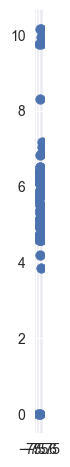

In [39]:
gdf.plot()

## Visualización inicial de la distribución geográfica de los hurtos

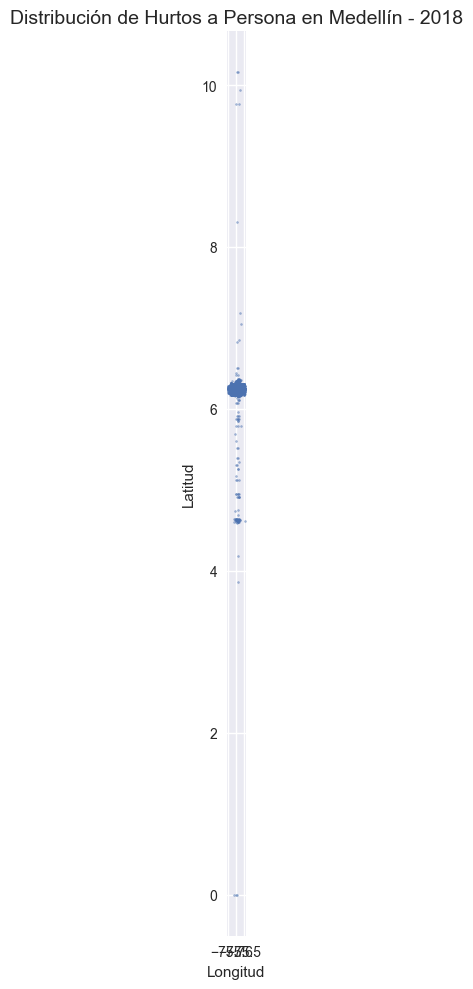

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, markersize=2, alpha=0.5)
ax.set_title('Distribución de Hurtos a Persona en Medellín - 2018', fontsize=14)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.tight_layout()
plt.show()

ValueError: Contour levels must be increasing

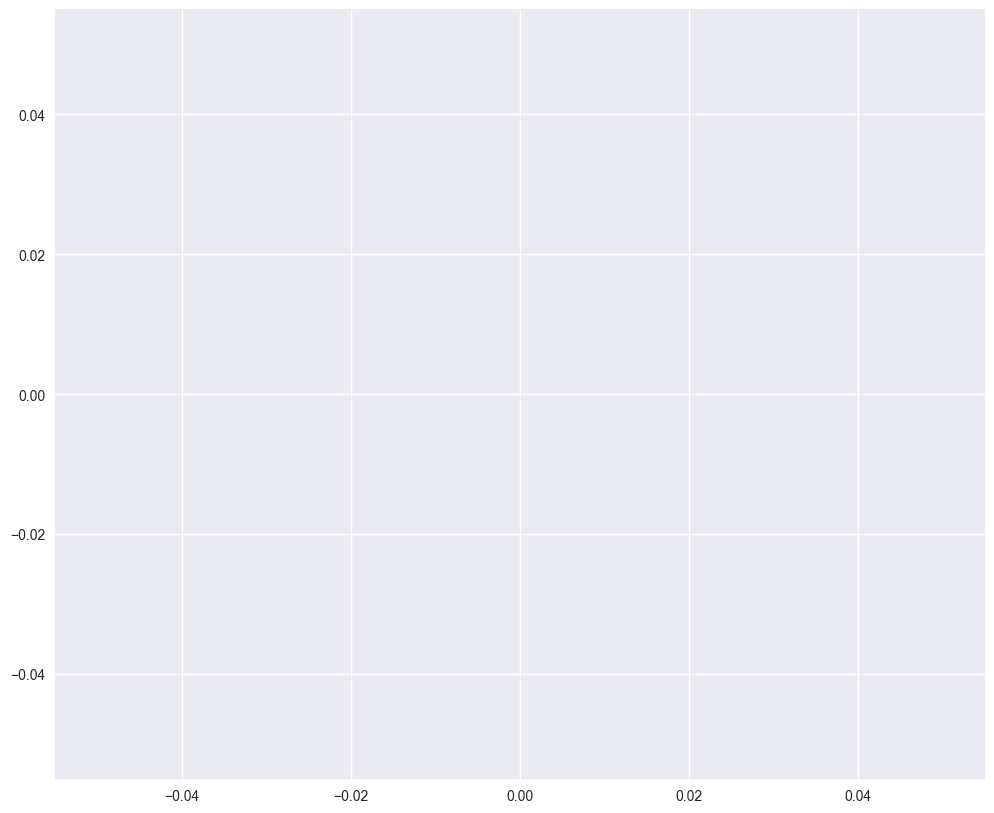

In [ ]:
df_plot = df_clean[['latitud', 'longitud']].dropna()

# Crear heatmap con KDE de seaborn
plt.figure(figsize=(12, 10))
sns.kdeplot(
    data=df_plot,
    x='longitud',
    y='latitud',
    fill=True,
    cmap='Reds',
    thresh=0.0001,  # Reduced threshold to include more data
    bw_adjust=0.5,
    levels=100
)
plt.title('Mapa de Densidad de Hurtos a Persona - Medellín 2018', fontsize=14)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.tight_layout()
plt.show()